<a href="https://colab.research.google.com/github/PremKumar-V/ML_Projects/blob/main/NamesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests

In [2]:
DATA_LINK = 'https://download.pytorch.org/tutorial/data.zip'

In [3]:
data = requests.get(DATA_LINK)

with open('data.zip', 'wb') as file:
    file.write(data.content)

In [4]:
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/data/names/*.txt'))

['data/data/names/Japanese.txt', 'data/data/names/Vietnamese.txt', 'data/data/names/Italian.txt', 'data/data/names/Chinese.txt', 'data/data/names/Russian.txt', 'data/data/names/Irish.txt', 'data/data/names/Czech.txt', 'data/data/names/Greek.txt', 'data/data/names/German.txt', 'data/data/names/Portuguese.txt', 'data/data/names/French.txt', 'data/data/names/Dutch.txt', 'data/data/names/Korean.txt', 'data/data/names/Scottish.txt', 'data/data/names/Polish.txt', 'data/data/names/English.txt', 'data/data/names/Arabic.txt', 'data/data/names/Spanish.txt']


In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [7]:
import torch

In [8]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.8580, -2.7906, -2.9680, -2.8766, -2.7931, -2.9417, -2.9685, -2.7633,
         -2.8491, -2.9770, -2.9035, -2.9536, -2.9049, -2.8709, -2.8774, -2.9140,
         -2.9060, -2.9456]], grad_fn=<LogSoftmaxBackward0>)
('Greek', 7)


In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Kaplanek
category = French / line = Duchamps
category = French / line = Abraham
category = Greek / line = Kreskas
category = Korean / line = Gwang 
category = French / line = Leveque
category = Vietnamese / line = Lam
category = Chinese / line = Teoh
category = Chinese / line = Tao
category = Portuguese / line = Gouveia


In [13]:
criterion = nn.NLLLoss()

In [14]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.2418 Hwang / Korean ✓
10000 10% (0m 13s) 2.4818 Brown / English ✗ (Scottish)
15000 15% (0m 19s) 1.6557 Berger / French ✗ (German)
20000 20% (0m 30s) 5.2434 Haanrade / Irish ✗ (Dutch)
25000 25% (0m 38s) 0.8117 Kuijpers / Dutch ✓
30000 30% (0m 44s) 3.9425 Shakhno / Japanese ✗ (Russian)
35000 35% (0m 51s) 0.9508 Acquarone / Italian ✓
40000 40% (0m 57s) 0.6320 Kudara / Japanese ✓
45000 45% (1m 4s) 3.0742 Winograd / Arabic ✗ (Polish)
50000 50% (1m 10s) 0.7656 Stuber / German ✓
55000 55% (1m 17s) 1.7174 Kalogeria / Spanish ✗ (Greek)
60000 60% (1m 23s) 0.9527 Baburkin / Russian ✓
65000 65% (1m 30s) 0.1937 Thuy / Vietnamese ✓
70000 70% (1m 37s) 4.8877 Gravari / Italian ✗ (Greek)
75000 75% (1m 46s) 0.2481 Liatos / Greek ✓
80000 80% (1m 52s) 0.4959 Chellos / Greek ✓
85000 85% (1m 59s) 1.5487 Hamilton / Scottish ✗ (English)
90000 90% (2m 6s) 2.8363 Lange / French ✗ (German)
95000 95% (2m 13s) 0.0713 Pyanochenko / Russian ✓
100000 100% (2m 19s) 0.2641 Nicchi / Italian ✓


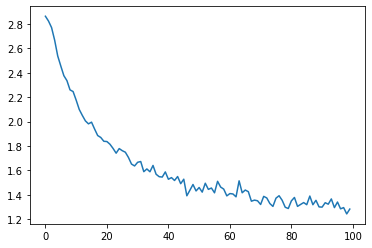

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-17-ad3198427f7e>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-17-ad3198427f7e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


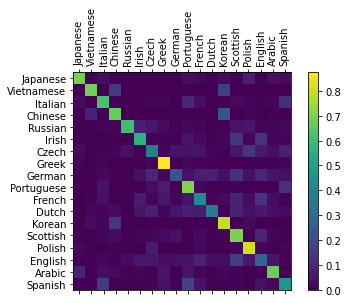

In [17]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.72) Russian
(-1.06) Czech
(-2.33) English

> Jackson
(-0.45) Scottish
(-1.47) English
(-3.13) Russian

> Satoshi
(-0.82) Japanese
(-1.59) Italian
(-2.35) Portuguese
